In [1]:
#James Gibson
#12/03/22
#Script is based on https://www.tensorflow.org/tutorials/keras/regression

#Error warning about tensorflow

#2022-12-03 17:53:16.980823: I tensorflow/core/platform/cpu_feature_guard.cc:193] 
#This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use 
#the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
#To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path
import seaborn as sns
#import rasterio
#import geopandas as gpd
#import rioxarray

In [4]:
#Loading my data set (except for 2021 data)
data = r'/Users/bustergibson/documents/ml/pm25_aod_complete.csv'
dataset = pd.read_csv(data)
dataset = dataset.loc[:, ~dataset.columns.str.contains('^Unnamed')]
dataset = dataset[dataset['YEAR'] < 2021]
dataset = dataset[['SITE_LATITUDE','SITE_LONGITUDE','YEAR','PM25','AOD']]
dataset

,SITE_LATITUDE,SITE_LONGITUDE,YEAR,PM25,AOD
0,41.170833,-73.194722,2010,8.747368,0.106736
1,41.399167,-73.443056,2010,9.161345,0.073683
2,41.784722,-72.631667,2010,7.658380,0.115273
3,41.821342,-73.297257,2010,5.436066,0.104100
4,41.301400,-72.902871,2010,8.927290,0.081273
...,...,...,...,...,...
1095,41.874668,-71.379971,2020,8.146875,0.077750
1096,41.841039,-71.360970,2020,6.500000,0.077750
1097,42.887590,-73.249840,2020,5.616667,0.112200
1098,44.528390,-72.868840,2020,3.840375,0.100989


In [5]:
#Create training and test data sets
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

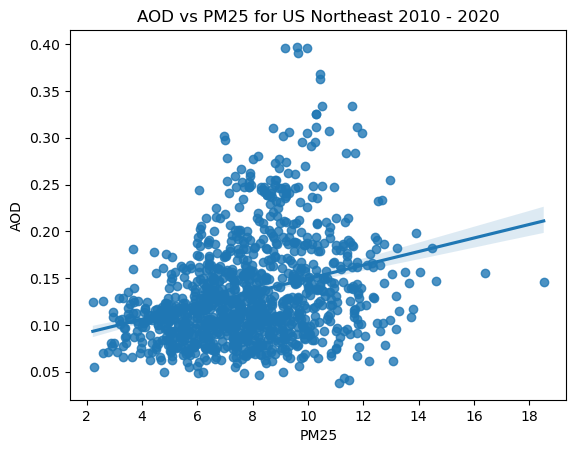

In [6]:
#Linear regression plot to look at coorelation between AOD and PM 2.5
sns.regplot(x="PM25", y="AOD", data=dataset)
plt.title('AOD vs PM25 for US Northeast 2010 - 2020')
plt.show()

In [7]:
#Linear Regression
train_features = train_dataset.copy()
test_features = test_dataset.copy()

#We are predicting PM 2.5
train_labels = train_features.pop('PM25')
test_labels = test_features.pop('PM25')


In [8]:
#We need to normalize the data
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
SITE_LATITUDE,41.497926,1.336925
SITE_LONGITUDE,-74.431833,2.864633
YEAR,2015.003409,3.154171
PM25,7.825442,2.217769
AOD,0.133624,0.055491


In [9]:
#Normalization
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))


2022-12-20 18:40:53.573769: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
#First we are going to obtain a linear regression model simply testing the ability of AOD to predict to PM 2.5
#Ex. 
# linear_model = tf.keras.Sequential([
#     normalizer,
#     layers.Dense(units=1)
# ])

aod = np.array(train_features['AOD'])
aod_normalizer = layers.Normalization(input_shape=[1,], axis=None)
aod_normalizer.adapt(aod)



In [11]:
aod_model = tf.keras.Sequential([
    aod_normalizer,
    layers.Dense(units=1)
])

aod_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [12]:
aod_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [13]:
%%time
history = aod_model.fit(
    train_features['AOD'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

/Users/bustergibson/opt/anaconda3/envs/keras/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


CPU times: user 2.24 s, sys: 264 ms, total: 2.51 s
Wall time: 2.03 s


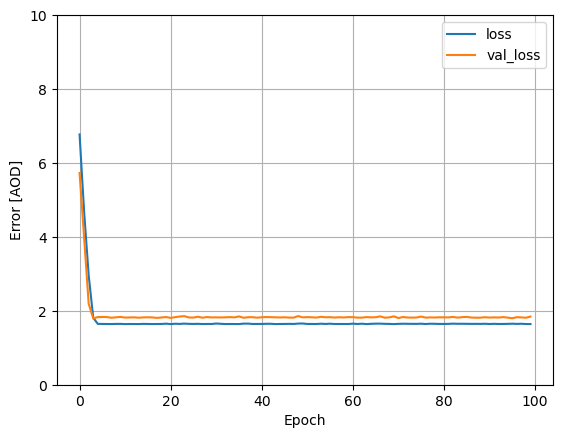

In [14]:
plt.clf()
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [AOD]')
  plt.legend()
  plt.grid(True)

plot_loss(history)
plt.show()


In [15]:
#Collect the results on the test set for later
test_results = {}

test_results['aod_model'] = aod_model.evaluate(
    test_features['AOD'],
    test_labels, verbose=0)

In [16]:
x = tf.linspace(0.0, .5, 100)
y = aod_model.predict(x)

4/4 [==============================] - 0s 636us/step


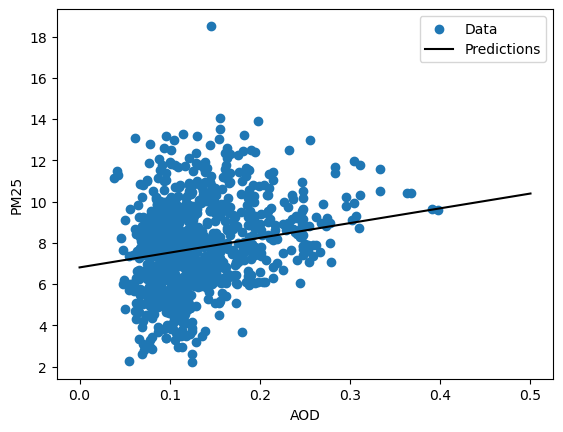

In [17]:
def plot_aod(x, y):
  plt.scatter(train_features['AOD'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('AOD')
  plt.ylabel('PM25')
  plt.legend()

plot_aod(x,y)
plt.show()